<a href="https://colab.research.google.com/github/xihajun/Android-hls/blob/master/Copy_of_2019_03_22_style_transfer_2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


100
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


s
end
101
s
end
102
s
end
103
s
end
104
s
end
105
s
end
106
s
end
107
s
end
108
s
end
109
s
end
110
s
end
111
s
end
112
s
end
113
s
end
114
s
end
115
s
end
116
s
end
117
s
end
118
s
end
119
120
s
end
121
s
end
122
s
end
123
s
end
124
s
end
125
s
end
126
s
end
127
s
end
128
s
end
129
s
end
130
s
end
131
s
end
132
s
end
133
s
end
134
s
end
135
s
end
136
s
end
137
s
end
138
s
end
139
s
end
140
s
end
141
s
end
142



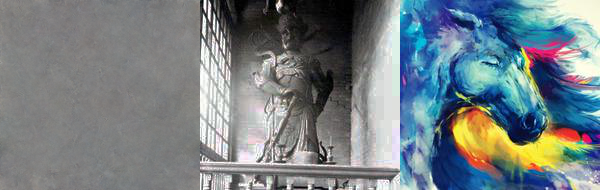

143



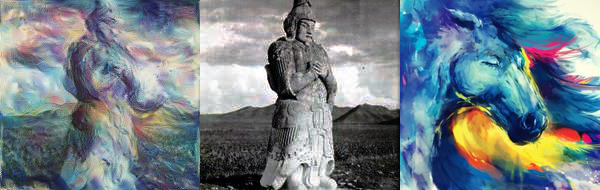

144



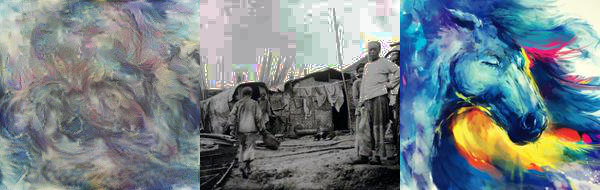

145
s
end
146



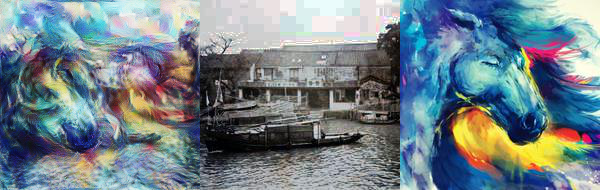

147
s
end
148
s
end
149
s
end
150
s
end
151
s
end
152
s
end
153
s
end
154
s
end
155
s
end
156
s
end
157
s
end
158
s
end
159
s
end
160
s
end
161
s
end
162
s
end
163
s
end
164
s
end
165
s
end
166
s
end
167
s
end
168
s
end
169
s
end
170
s
end
171
s
end
172
s
end
173
s
end
174
s
end
175
s
end
176
s
end
177
s
end
178
s
end
179
s
end
180
s
end
181
s
end
182
s
end
183
s
end
184
s
end
185
s
end
186
s
end
187
s
end
188
s
end
189
s
end
190
s
end
191
s
end
192
s
end
193
s
end
194
s
end
195
s
end
196
s
end
197
s
end
198
s
end
199
s
end
200


In [0]:
# Imports

import numpy as np
import tensorflow as tf

from lucid.modelzoo import vision_models
from lucid.misc.io import show, load, save
from lucid.misc.tfutil import create_session

import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
model = vision_models.InceptionV1()
model.load_graphdef()

from lucid.optvis.objectives import wrap_objective

from PIL import Image
from PIL import Image, ImageOps
from resizeimage import resizeimage

tf.test.is_gpu_available()

# upload data.csv
# upload style1.png style2.png style3.png
style_layers = [
  'conv2d2',
  'mixed3a',
  'mixed4a',
  'mixed4b',
  'mixed4c',
]

content_layers = [
  'mixed3b',
]
import csv
import pandas as pd 
# Read data from file 'filename.csv' 
# (in the same directory that your python process is based)
# Control delimiters, rows, column names with read_csv (see later) 
data = pd.read_csv("data.csv") 
# Load data 
url_list = list(data['IMAGE LINK'])

def style_transfer_param(content_image, style_image, decorrelate=True, fft=True):
  style_transfer_input = param.image(*content_image.shape[:2], decorrelate=decorrelate, fft=fft)[0]
  content_input = content_image
  style_input = tf.random_crop(style_image, content_image.shape)
  return tf.stack([style_transfer_input, content_input, style_input])

# these constants help remember which image is at which batch dimension
TRANSFER_INDEX = 0
CONTENT_INDEX = 1
STYLE_INDEX = 2
content_image = load("style1.png")[..., :3]
style_image = load("style2.png")[..., :3]

def mean_L1(a, b):
  return tf.reduce_mean(tf.abs(a-b))

@wrap_objective
def activation_difference(layer_names, activation_loss_f=mean_L1, transform_f=None, difference_to=CONTENT_INDEX):
  def inner(T):
    # first we collect the (constant) activations of image we're computing the difference to
    image_activations = [T(layer_name)[difference_to] for layer_name in layer_names]
    if transform_f is not None:
      image_activations = [transform_f(act) for act in image_activations]
    
    # we also set get the activations of the optimized image which will change during optimization
    optimization_activations = [T(layer)[TRANSFER_INDEX] for layer in layer_names]
    if transform_f is not None:
      optimization_activations = [transform_f(act) for act in optimization_activations]
    
    # we use the supplied loss function to compute the actual losses
    losses = [activation_loss_f(a, b) for a, b in zip(image_activations, optimization_activations)]
    return tf.add_n(losses) 
    
  return inner

def gram_matrix(array, normalize_magnitue=True):
  channels = tf.shape(array)[-1]
  array_flat = tf.reshape(array, [-1, channels])
  gram_matrix = tf.matmul(array_flat, array_flat, transpose_a=True)
  if normalize_magnitue:
    length = tf.shape(array_flat)[0]
    gram_matrix /= tf.cast(length, tf.float32)
  return gram_matrix


style_transfer_param(content_image, style_image).shape
import os
os.system("mkdir images")# save the original images
os.system("mkdir new")# save the artificial images
import string
for i in range(150,200):
  try:
    #download
    url1 = url_list[i]
    #url1 = 'http://museums.bristol.gov.uk/multimedia/entry.php?request=resource&irn=188999&width=1000&format=jpeg'
    download = "wget --output-document hello.jpg '"+url1+"'"
    os.system(download)
    #os.system('wget --output-document auto.jpg {}'.format(url1))
    print(i)
    with open('hello.jpg', 'r+b') as f:
      with Image.open(f) as image:
          cover = resizeimage.resize_cover(image, [200, 190])
          cover.save('images/auto'+str(i)+'.jpg', image.format)
    # image optimisation
    ImageOps.equalize( Image.open("images/auto"+str(i)+".jpg")).save("images/auto"+str(i)+".jpg")
    os.system('rm hello.jpg')
    content_image = load('images/auto'+str(i)+'.jpg')[...,:3]
    style_image = load("style2.png")[..., :3] # choose a style

    param_f = lambda: style_transfer_param(content_image, style_image)
    content_obj = 100 * activation_difference(content_layers, difference_to=CONTENT_INDEX)
    content_obj.description = "Content Loss"

    style_obj = activation_difference(style_layers, transform_f=gram_matrix, difference_to=STYLE_INDEX)
    style_obj.description = "Style Loss"

    objective = - content_obj - style_obj

    vis = render.render_vis(model, objective, param_f=param_f, thresholds=[512], verbose=False, print_objectives=[content_obj, style_obj])[-1]
    savepath = "new1/" + data['Keywords'][i] + data['Year'][i] +"_num_"+ str(i) + ".jpg"
    print("s")
    save(vis[0], savepath)
    print("end")
  except:
    continue